In [1]:
import torch
from torch.utils.data import DataLoader, random_split

import numpy as np
import matplotlib.pyplot as plt

from PINN import PINN
from Siren import HSiren
from GridDataset3D import GridDataset as G3D

generator = torch.Generator()
generator.manual_seed(42);

## SiLU Wake Steering (3D)

In [2]:
dataset = G3D(dir="../../data/Case_01/measurements_flow/postProcessing_BL/winSpeedMapVector/",
            turbine_csv="../../data/Case_01/measurements_turbines/30000_BL/rot_yaw_combined.csv",
            wind_csv="../../data/Case_01/winDir_processed.csv", 
            data_type="wake", 
            wake_dir="../../data/Case_01/measurements_flow/postProcessing_LuT2deg_internal/winSpeedMapVector/",
            wake_turbine_csv="../../data/Case_01/measurements_turbines/30000_LuT2deg_internal/rot_yaw_combined.csv",
            time_scaling_factor=1/9.6)

_, _, test = random_split(dataset, [0.7, 0.15, 0.15], generator=generator)

test_loader = DataLoader(test, batch_size=1, shuffle=True, num_workers=4)

len(test_loader)

360

In [3]:
epoch = 623
hidden_size = 256
physics_coef = 0.01
depth = 5

checkpoint = torch.load(f"models/SiLU{hidden_size}-d{depth}-p{physics_coef}-f/model{epoch}.pt")

checkpoint.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'train_losses', 'val_losses'])

In [4]:
best_epoch = np.argsort(checkpoint['val_losses']['total'])[0]+1

best_epoch, checkpoint['train_losses']['total'][best_epoch-1], checkpoint['val_losses']['total'][best_epoch-1]

(620, 0.0034012380665877744, 0.0034277206070126138)

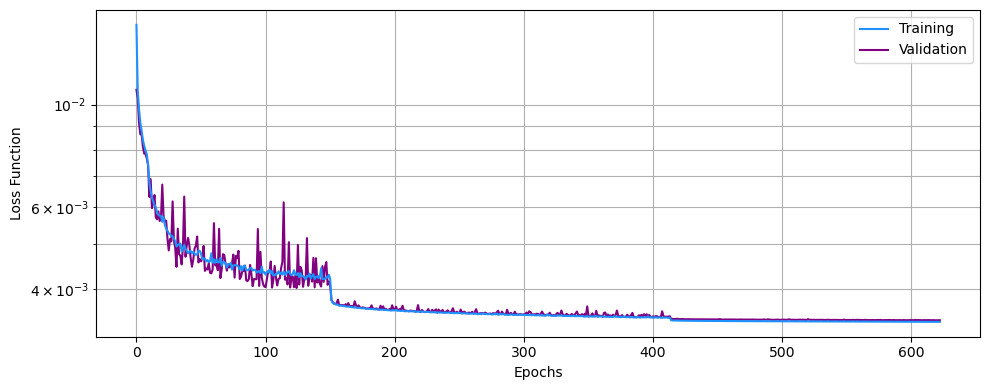

In [5]:
fig, ax = plt.subplots(figsize=(10,4))

ax.plot(checkpoint['train_losses']['total'], label="Training", zorder=3, color="dodgerblue")
ax.plot(checkpoint['val_losses']['total'], label="Validation", zorder=2, color="purple")

ax.set_xlabel("Epochs")
ax.set_ylabel("Loss Function")

ax.set_yscale("log")
ax.legend()
ax.grid(which="both")

fig.tight_layout()

In [6]:
checkpoint = torch.load(f"models/SiLU{hidden_size}-d{depth}-p{physics_coef}-f/model{best_epoch}.pt")

model = PINN(in_dimensions=26, hidden_size=hidden_size, out_dimensions=4)

model.load_state_dict(checkpoint['model_state_dict'])

model.cuda().eval();

In [7]:
target_fields = []
output_fields = []

with torch.no_grad():
    for inputs, targets in test_loader:        
        inputs = inputs.flatten(0, 1).float().cuda(non_blocking=True)
        targets = targets.flatten(0, 1).float().cuda(non_blocking=True)
        
        outputs, _ = model(inputs)

        target_fields.append(targets.reshape(300, 300, 3).detach().cpu())
        output_fields.append(outputs.reshape(300, 300, 4).detach().cpu())

targ_tensor = torch.stack(target_fields).flatten(0, 2) 
out_tensor = torch.stack(output_fields)[:, :, :, :3].flatten(0, 2) 
torch.nn.functional.mse_loss(targ_tensor, out_tensor) * 64

tensor(0.2162)

In [8]:
sample = -1

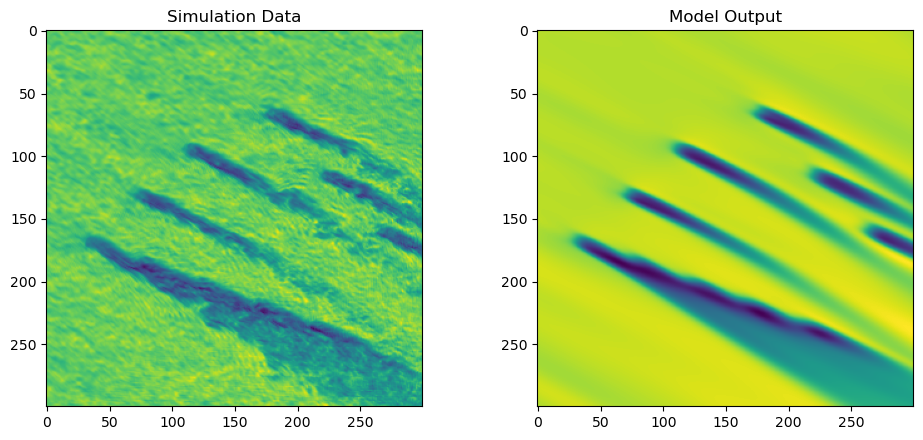

In [9]:
sample += 1

squared_error = (output_fields[sample][:, :, 0] - target_fields[sample][:, :, 0]).pow(2)

fig, ax = plt.subplots(ncols=2, figsize=(10, 4.5))

ax[0].imshow(target_fields[sample][:, :, 0])
ax[1].imshow(output_fields[sample][:, :, 0])
# im = ax[2].imshow(squared_error, cmap='hot')
# fig.colorbar(im)

ax[0].set_title("Simulation Data")
ax[1].set_title("Model Output")
# ax[2].set_title("Model Squared Error")

fig.tight_layout()

# fig.savefig(f"figures/silu-latest-{sample}.png")

## HSiren

In [10]:
dataset = G3D(dir="../../data/Case_01/measurements_flow/postProcessing_BL/winSpeedMapVector/",
            turbine_csv="../../data/Case_01/measurements_turbines/30000_BL/rot_yaw_combined.csv",
            wind_csv="../../data/Case_01/winDir_processed.csv", 
            data_type="wake", 
            wake_dir="../../data/Case_01/measurements_flow/postProcessing_LuT2deg_internal/winSpeedMapVector/",
            wake_turbine_csv="../../data/Case_01/measurements_turbines/30000_LuT2deg_internal/rot_yaw_combined.csv",
            time_scaling_factor=1/9.6)

_, _, test = random_split(dataset, [0.7, 0.15, 0.15], generator=generator)

test_loader = DataLoader(test, batch_size=1, shuffle=True, num_workers=4)

len(test_loader)

360

In [11]:
omega = 10
epoch = 716
physics_coef = 0.01

checkpoint = torch.load(f"models/HSiren{omega}-p{physics_coef}-f/model{epoch}.pt")

best_epoch = np.argsort(checkpoint['val_losses']['total'])[0]+1
best_epoch, checkpoint['train_losses']['total'][best_epoch-1], checkpoint['val_losses']['total'][best_epoch-1]

(699, 0.0040502003631055624, 0.0038957784754327603)

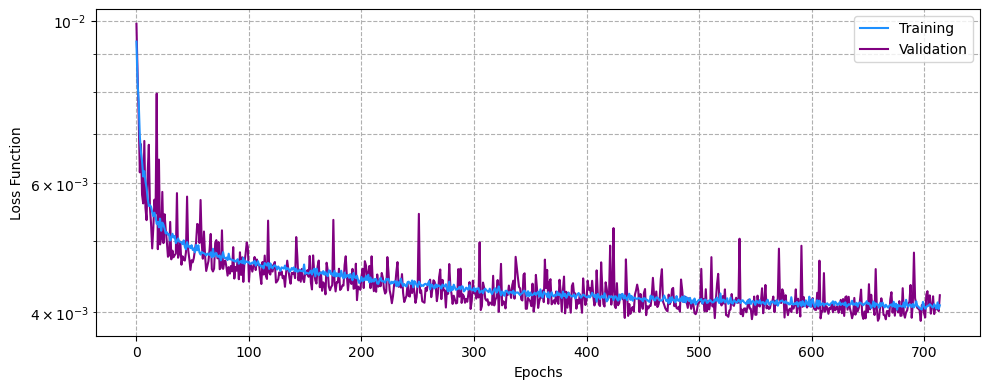

In [12]:
fig, ax = plt.subplots(figsize=(10,4))

ax.plot(checkpoint['train_losses']['total'][1:], label="Training", zorder=3, color="dodgerblue")

ax.plot(checkpoint['val_losses']['total'][1:], label="Validation", zorder=2, color="purple")

ax.legend()

ax.set_yscale("log")
ax.grid(ls="--", which="both", zorder=0)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss Function")

fig.tight_layout()

KeyError: 'density'

In [13]:
model = HSiren(in_features=26, 
               hidden_features=128, 
               hidden_layers=5, 
               out_features=4, 
               outermost_linear=True,
               hidden_omega_0=omega).cuda()

checkpoint = torch.load(f"models/HSiren{omega}-p{physics_coef}-f/model{best_epoch}.pt")

try:
    del checkpoint['model_state_dict']['density']
except:
    pass

model.load_state_dict(checkpoint['model_state_dict'])

model.cuda().eval();

RuntimeError: Error(s) in loading state_dict for HSiren:
	Unexpected key(s) in state_dict: "density". 

In [160]:
target_fields = []
output_fields = []

with torch.no_grad():
    for inputs, targets in test_loader:        
        inputs = inputs.flatten(0, 1).float().cuda(non_blocking=True)
        targets = targets.flatten(0, 1).float().cuda(non_blocking=True)

        outputs, _ = model(inputs)

        target_fields.append(targets.reshape(300, 300, 3).detach().cpu())
        output_fields.append(outputs.reshape(300, 300, 4).detach().cpu())

targ_tensor = torch.stack(target_fields).flatten(0, 2) 
out_tensor = torch.stack(output_fields)[:, :, :, :3].flatten(0, 2) 
torch.nn.functional.mse_loss(targ_tensor, out_tensor) * 64

In [161]:
sample = -1

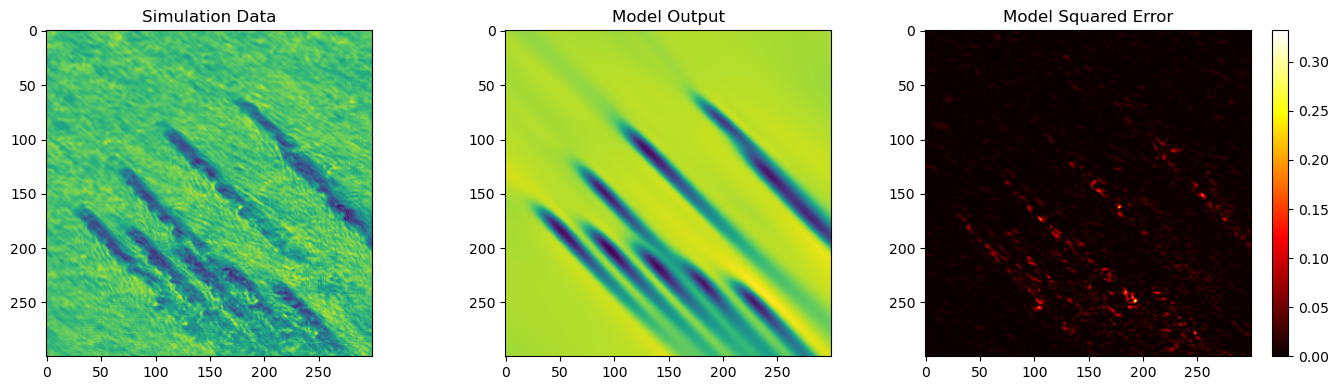

In [177]:
sample += 1
squared_error = (output_fields[sample][:, :, 0] - target_fields[sample][:, :, 0]).pow(2)

fig, ax = plt.subplots(ncols=3, figsize=(14, 4))

ax[0].imshow(target_fields[sample][:, :, 0])
ax[1].imshow(output_fields[sample][:, :, 0])
im = ax[2].imshow(squared_error, cmap='hot')
fig.colorbar(im)

ax[0].set_title("Simulation Data")
ax[1].set_title("Model Output")
ax[2].set_title("Model Squared Error")

fig.tight_layout()